In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split


import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.5 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

### setting up dataset Path

In [5]:
dataset_path = '/kaggle/input/car-plate-detection'

In [6]:
import re 

def the_number_in_the_string(file_name):
    match = re.search(r'(\d+)',file_name)
    if match:
        return int(match.group(0))
    else:
        return 0
    
    
print(the_number_in_the_string("file123.txt"))
print(the_number_in_the_string("no_numbers_here"))

123
0


# formatting the XML File and creating dataframe

In [7]:
# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [8]:
# splitting the dataset into train, test and val

train, test = train_test_split(alldata, test_size=0.1, random_state=42)
train, val = train_test_split(train, train_size = 8/9, random_state=42)

print(f"""
train : {len(train)}
val : {len(val)}
test : {len(test)}
""")


train : 345
val : 44
test : 44



In [9]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [10]:
# creating the folder structure of dataset in the yolo format

def make_spli_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [12]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [13]:
os.getcwd()

'/kaggle/working'

In [14]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [15]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.7MB/s]


In [16]:
model.train(
    data = 'datasets.yaml',
    epochs = 100,
    batch = 16,
    device = 'cuda',
    imgsz = 320,
    cache = True
)

Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 57.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 432.86it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 195.97it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 473.59it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 183.28it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.665G      1.746      3.536      1.314         18        320: 100%|██████████| 22/22 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         44         44    0.00371      0.841        0.2     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.635G      1.591       2.31       1.07         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

                   all         44         44    0.00379      0.864      0.246     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.644G      1.577      1.602      1.132         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44    0.00425      0.864     0.0143    0.00697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.635G      1.534      1.504      1.164         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         44         44     0.0045      0.909      0.341      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.635G      1.538      1.387      1.177         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         44         44          1      0.171       0.61      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.638G      1.517      1.354      1.151         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         44         44      0.648      0.295      0.365      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.638G      1.422      1.228      1.099         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.157      0.273      0.144     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.635G      1.458      1.218      1.133         26        320: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]

                   all         44         44      0.606      0.455      0.514      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.635G      1.412      1.112      1.123         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.106      0.227      0.068     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.635G      1.428      1.083       1.12         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

                   all         44         44      0.824      0.746       0.76      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.635G      1.367      1.033      1.112         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

                   all         44         44      0.762      0.818      0.789      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.635G      1.425      1.024      1.118         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         44         44      0.878      0.817      0.836      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.635G      1.359     0.9818      1.098         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.817      0.813       0.82      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.635G      1.345     0.9768      1.079         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         44         44        0.9      0.795      0.899      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.635G      1.312     0.9605      1.069         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         44         44      0.806      0.847      0.898      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.635G      1.312     0.9187       1.07         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         44         44      0.856      0.864      0.841      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.635G      1.281     0.9234      1.069         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         44         44       0.85      0.904      0.922      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.635G      1.328     0.9112       1.08         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44      0.903      0.864      0.888      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.635G      1.223     0.8708      1.032         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

                   all         44         44      0.902      0.841      0.889      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.635G       1.27     0.8781      1.058         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.842      0.886      0.825      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.635G       1.27     0.8535      1.047         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all         44         44      0.899      0.813      0.861      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.635G      1.222      0.823      1.032         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all         44         44      0.925      0.773      0.837      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.635G      1.214     0.7984      1.037         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44      0.922      0.818      0.902       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.635G      1.193     0.7913      1.025         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         44         44      0.938      0.818      0.894      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.635G       1.23     0.7846      1.039         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all         44         44      0.858      0.864      0.877      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.635G      1.188     0.7763      1.019         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.783      0.903      0.894       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.635G      1.174     0.7482      1.024         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]

                   all         44         44      0.972      0.787      0.896      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.635G      1.151     0.7409     0.9955         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.929      0.887      0.903      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.635G      1.174     0.7547      1.016         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         44         44      0.905      0.864      0.896      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.635G      1.146     0.7364     0.9993         11        320: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

                   all         44         44      0.948      0.836      0.919      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.635G      1.107     0.7216      1.014          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

                   all         44         44      0.901      0.886      0.918      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.635G      1.092     0.7338     0.9992         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all         44         44      0.912      0.886      0.926      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.635G      1.159     0.7502     0.9979         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]

                   all         44         44      0.777      0.872       0.89      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.635G      1.184      0.753      1.012         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         44         44      0.948       0.83      0.902      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.635G      1.117     0.6772      1.003         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         44         44      0.924      0.864      0.931      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.635G      1.088     0.6608     0.9676         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]

                   all         44         44      0.911      0.841      0.898      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.635G      1.059     0.6792     0.9759         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         44         44      0.846      0.909      0.899      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.635G      1.061     0.6784     0.9732         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         44         44      0.863      0.858      0.907      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.635G      1.062      0.691     0.9965         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]

                   all         44         44        0.9      0.864      0.925      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.635G      1.071     0.6776     0.9728         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         44         44      0.924      0.835      0.899      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.635G      1.121     0.6689     0.9869         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         44         44       0.87      0.818      0.871      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.638G      1.034     0.6715     0.9716          8        320: 100%|██████████| 22/22 [00:02<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         44         44      0.878      0.886      0.898      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.635G      1.046     0.6836     0.9823         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         44         44        0.9      0.819      0.909      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.635G      1.075     0.6636     0.9955         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         44         44      0.949      0.854      0.882       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.635G      1.077      0.676     0.9901         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         44         44        0.9      0.841      0.868      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.635G      1.029     0.6523     0.9788         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.947      0.818      0.874      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.635G      1.039     0.6382     0.9749         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         44         44      0.923      0.886      0.897      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.635G     0.9915     0.6155     0.9702         14        320: 100%|██████████| 22/22 [00:02<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         44         44      0.908      0.864      0.902      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.635G     0.9923     0.6173     0.9472         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]

                   all         44         44      0.925      0.841      0.885      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.638G      1.009     0.6176     0.9513         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]

                   all         44         44      0.925      0.841      0.883        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.635G      1.011     0.6157     0.9538         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]

                   all         44         44      0.898      0.841      0.895      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.635G     0.9873     0.6155     0.9556         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         44         44      0.822      0.841      0.863      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.635G     0.9471     0.5867      0.947         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

                   all         44         44       0.82      0.864      0.856      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.638G     0.9577     0.5787      0.948         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]

                   all         44         44      0.925      0.838       0.89      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.635G     0.9405     0.5856     0.9315         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.937      0.818      0.903      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.635G     0.9696     0.5876     0.9382         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         44         44      0.825       0.86       0.89      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.635G     0.9236     0.5669     0.9459         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]

                   all         44         44      0.836      0.886      0.897      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.635G     0.9172     0.5743     0.9434         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all         44         44      0.882      0.852       0.89      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.635G     0.9336     0.5733     0.9448         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         44         44      0.881      0.842      0.915      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.635G     0.8959     0.5547     0.9372         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


                   all         44         44      0.902      0.886       0.93      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.635G      0.957     0.5689     0.9376         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         44         44      0.883      0.856      0.924      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.635G     0.9135     0.5707     0.9303         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44      0.924      0.833      0.913      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.635G     0.9044     0.5533     0.9141         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         44         44       0.89      0.818      0.884      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.635G      0.881     0.5425     0.9288         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.892      0.841      0.866      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.635G     0.9007     0.5435     0.9353         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         44         44      0.877      0.841      0.857      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.635G     0.9017     0.5414     0.9281         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         44         44      0.851      0.841      0.856       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.635G     0.8832     0.5463     0.9386         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         44         44      0.874      0.841      0.859      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.635G     0.8639     0.5478     0.9176         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         44         44      0.921      0.818       0.89      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.635G     0.8517     0.5263     0.9262         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

                   all         44         44       0.94      0.818       0.92      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      0.64G     0.8426     0.5208     0.9172         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         44         44      0.944      0.818      0.895      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.635G     0.8778     0.5214     0.9133         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         44         44      0.936      0.818       0.91      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.635G     0.8337     0.5135     0.9306         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         44         44      0.939      0.818      0.897       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.635G     0.8683     0.5159     0.9216         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         44         44      0.919      0.818      0.893      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.635G     0.8438     0.5093     0.9124         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]

                   all         44         44      0.922      0.807        0.9      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.635G     0.8372     0.5043     0.9108         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         44         44        0.9      0.818      0.885      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.635G     0.8524     0.5083     0.9122         27        320: 100%|██████████| 22/22 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         44         44      0.936      0.841      0.903      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.635G      0.854     0.5227     0.9206         10        320: 100%|██████████| 22/22 [00:02<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

                   all         44         44      0.941      0.841      0.916      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.638G     0.7864     0.4907     0.9036         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         44         44      0.948      0.829      0.913      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.635G     0.8216     0.4853     0.9138         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]

                   all         44         44      0.948      0.836      0.913        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.638G     0.8519      0.497     0.9194         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44       0.91      0.841      0.897      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.635G     0.7745     0.4773     0.8979         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]

                   all         44         44       0.91      0.841      0.896      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.635G      0.792     0.4899     0.9037         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         44         44      0.919      0.818      0.898      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.635G     0.7946     0.4876     0.9102         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         44         44      0.921      0.793      0.879      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.638G      0.811     0.4992     0.9039         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         44         44      0.898      0.841      0.899      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.635G     0.7672     0.4659     0.9007         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.922      0.818      0.888      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.635G     0.7789     0.4747     0.8969         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         44         44      0.875      0.864      0.896      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.635G     0.7538     0.4614     0.8913         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.899      0.841      0.881      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.635G     0.7517     0.4562     0.8995         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         44         44      0.901      0.831      0.892      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.635G     0.7862     0.4569     0.9065         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


                   all         44         44      0.877      0.864      0.892      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.635G     0.7844     0.4695      0.918         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.888      0.818       0.89      0.508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.635G      1.045     0.5877     0.9924          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

                   all         44         44      0.899      0.795      0.861      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.635G     0.9865      0.524     0.9741          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         44         44      0.917      0.773      0.852      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.633G     0.9799     0.5304     0.9817          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.915      0.773      0.857      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.635G     0.9521     0.4991     0.9747          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


                   all         44         44      0.928      0.795      0.884      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.635G     0.9861     0.5158     0.9767          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]

                   all         44         44      0.923      0.813      0.896       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.635G     0.9622     0.5154     0.9697          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         44         44      0.922      0.803      0.891      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.633G     0.9284     0.4868     0.9512          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]

                   all         44         44       0.91      0.818      0.893      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.635G     0.9528     0.4939     0.9406          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.907      0.818      0.892      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.633G      0.924     0.4985     0.9591          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         44         44       0.92      0.787      0.894      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.635G     0.9553     0.4974     0.9541          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         44         44      0.921      0.791      0.896      0.515



100 epochs completed in 0.084 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


                   all         44         44      0.943      0.818      0.895      0.525
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


lr/pg0,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁
lr/pg1,▂████▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
lr/pg2,▂▄▆██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▃▁▃▆▅▇█▇▇████████████████▇██████████▇▇██
metrics/mAP50-95(B),▁▁▃▃▇▇▆▆▇▇▇▇█▇▆▇▇▇▇█▇▇▇██▇▇███▇▇████████
metrics/precision(B),▁▆▇▇▇▇▇██▇████▇██▇█████████▇▇▇█████▇████
metrics/recall(B),█▁▁▆▇▇██▇▇▇█▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▃▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bb7d017ce80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

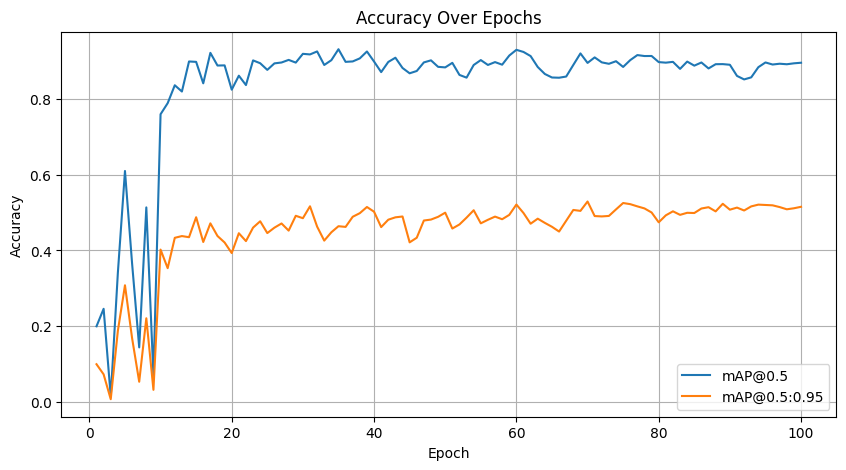

In [21]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [23]:
results = model.predict('/kaggle/input/car-plate-detection/images/Cars107.png')


image 1/1 /kaggle/input/car-plate-detection/images/Cars107.png: 192x320 1 license_plate, 10.1ms
Speed: 1.2ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)


In [24]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'license_plate'}
 obb: None
 orig_img: array([[[ 94, 114, 132],
         [ 87, 107, 125],
         [ 70,  90, 108],
         ...,
         [139, 156, 172],
         [135, 152, 168],
         [138, 155, 171]],
 
        [[ 79,  99, 117],
         [ 90, 110, 128],
         [ 90, 110, 128],
         ...,
         [118, 135, 151],
         [116, 133, 149],
         [117, 134, 150]],
 
        [[ 90, 110, 128],
         [ 96, 116, 134],
         [ 91, 111, 129],
         ...,
         [117, 134, 150],
         [117, 134, 150],
         [117, 134, 150]],
 
        ...,
 
        [[100, 115, 124],
         [100, 115, 124],
         [ 99, 114, 123],
         ...,
         [ 71,  80,  90],
         [ 74,  83,  93],
         [ 71,  80,  90]],
 
        [[102, 117, 126],
         [101, 116, 125],
         [ 99, 114, 123],
         ...,
         [ 

In [43]:
image = cv2.imread('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars152.png')
results = model.predict('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars152.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars152.png: 224x320 1 license_plate, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8725], device='cuda:0')
data: tensor([[ 94.5738, 258.5057, 197.3180, 283.8860,   0.8725,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (300, 467)
shape: torch.Size([1, 6])
xywh: tensor([[145.9459, 271.1958, 102.7442,  25.3802]], device='cuda:0')
xywhn: tensor([[0.3125, 0.9040, 0.2200, 0.0846]], device='cuda:0')
xyxy: tensor([[ 94.5738, 258.5057, 197.3180, 283.8860]], device='cuda:0')
xyxyn: tensor([[0.2025, 0.8617, 0.4225, 0.9463]], device='cuda:0')


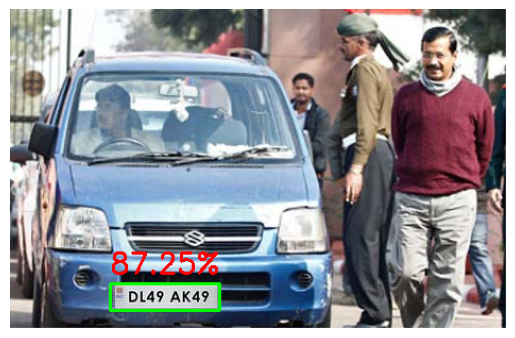

In [44]:
for result in results:
    for box in result.boxes:
        print(box)
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        
        cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(image, f"{confidence*100:.2f}%", (x1,y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
        
plt.imshow(image)
plt.axis('off')
plt.show()

In [25]:
def predict_and_plot(path_test_car):
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 41.1ms
Speed: 1.4ms preprocess, 41.1ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 320)


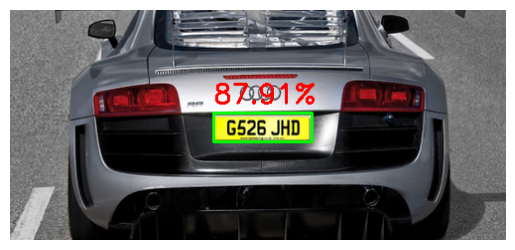

In [37]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 (no detections), 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


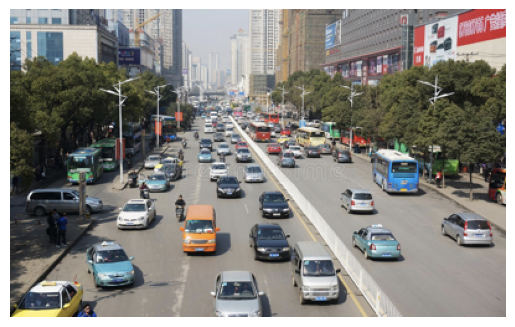

In [39]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars179.png: 224x320 1 license_plate, 8.8ms
Speed: 1.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)


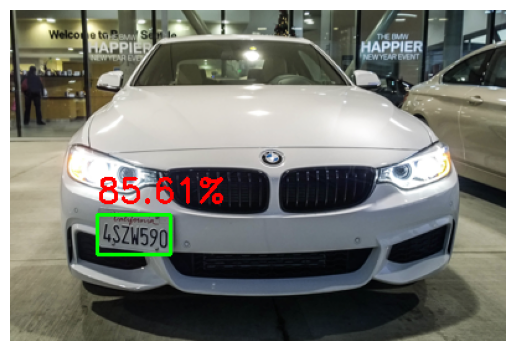

In [42]:
predict_and_plot(train.iloc[69].img_path)


# Implemnting Text Extraction

In [45]:
!pip3 install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [46]:
import pytesseract
from pytesseract import Output


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars428.png: 192x320 1 license_plate, 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 192, 320)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8731], device='cuda:0')
data: tensor([[142.8520, 127.8016, 259.6672, 157.3380,   0.8731,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (225, 400)
shape: torch.Size([1, 6])
xywh: tensor([[201.2596, 142.5698, 116.8152,  29.5364]], device='cuda:0')
xywhn: tensor([[0.5031, 0.6336, 0.2920, 0.1313]], device='cuda:0')
xyxy: tensor([[142.8520, 127.8016, 259.6672, 157.3380]], device='cuda:0')
xyxyn: tensor([[0.3571, 0.5680, 0.6492, 0.6993]], device='cuda:0')
Detected License Plate Number is : -DZI7 YXR_



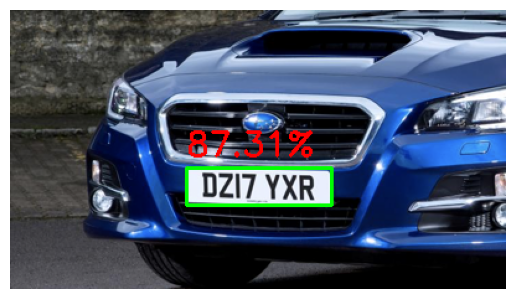

In [49]:
image = cv2.imread('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars428.png')
results = model.predict('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars428.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


for result in results:
    for box in result.boxes:
        print(box)
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        
        cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(image, f"{confidence*100:.2f}%", (x1,y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
        
        roi = image[y1:y2, x1:x2]
        
        text = pytesseract.image_to_string(roi, config = '--psm 6')
        print(f"Detected License Plate Number is : {text}")
        
plt.imshow(image)
plt.axis('off')
plt.show()

In [50]:
def predict_and_plot(path_test_car):
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 320)
Detected text: G526 JHD



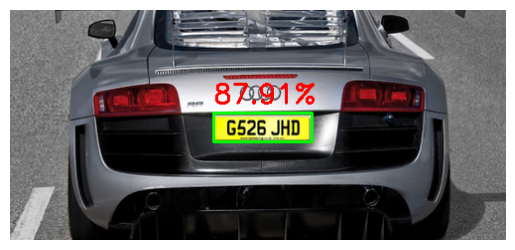

In [51]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 (no detections), 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


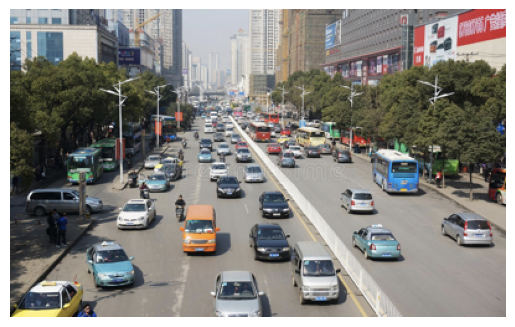

In [52]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 192)
Detected text: | JHNHAD |



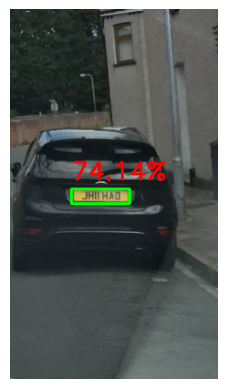

In [53]:
predict_and_plot(test.iloc[2].img_path)